# Correlation analysis
'''
Created on Tue 03 Mar 2020'''

Based on version Wed 19 Feb 2020 of correlation analysis



This Notebook is intended to do the entire correlation matrix analysis 
for the different trials, object configuration, object exploration.

## Importation of libraries and definition of specific data to use

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
cmap = cm.jet

Define mouse to analize as well as preprocessing analysis versions

- mouse -> mouse identity 
- decoding_v  -> decoding version 
- motion_correction_v - > motion correction version. 100 is aligned one
- alignment_v -> alignment version
- equalization_v -> equalization version
- source_extraction_v -> source extraction version
- component_evaluation_v -> component evaluation version
- registration_v -> registration version

- sf = 10 -> signal sampling frequency 
- re_sf= 20 -> resample integer (will take one every re_sf point ans use the mean)

In [3]:
mouse = 32365           ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 20                 ## value of resampling

session_now = 2 
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

Define all necesary directories from calcium activity, behavioural data, objects position and timeline

In [4]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/correlation/'

## Compare correlation matrix in multiple conditions

For comparison of multiple sessions, load all sessions and normalize the data trial by trial

In [5]:
correlation_matrix = []   ## correlation matrix that will contain all the correlation matrix of multiple sessions
task_list = []            ## condition list

for session in sessions:
    
    ## define task for plotting. This will cahnge for other mice!!!!
    if mouse == 56165 or mouse == 32364:
        if session == 1:
            task1 = 'OVERLAPPING'
        else:
            if session == 2:
                task1 = 'STABLE'
            else:
                task1 = 'RANDOM'
                
    if mouse == 32365:
        sessions = [2,3] ## sessions for this particular mouse
        if session == 2:
            task1 = 'RANDOM'
        else:
            if session == 3:
                task1 = 'OVERLAPPING'
            
    if mouse == 56166:
        if session== 1:
            task1 = 'RANDOM'
        else:
            if session== 2:
                task1 = 'OVERLAPPING'
                
    if mouse == 32363:
        sessions = [1,2] ## sessions for this particular mouse
        if session == 1:
            task1 = 'RANDOM'
        else:
            if session== 2:
                task1 = 'OVERLAPPING'
    
    if mouse == 32366:
        sessions = 3 ## sessions for this particular mouse
        if session_now == 3:
            task1 = 'RANDOM'

    file_name_session_1 = 'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{decoding_v}'+'.4.'+f'{100}'+\
                          '.'+f'{alignment_v}'+'.'+ f'{equalization_v}' +'.' + f'{source_extraction_v}'+'.' + \
                          f'{component_evaluation_v}' +'.'+ f'{registration_v}' + '.npy'
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{decoding_v}'+'.4.'+f'{1}'+\
                          '.'+f'{0}'+ '.pkl'
    beh_file_name_1 = 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_event_'+f'{re_sf}'+'.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = activity.shape[1]
    ##normalize neural activity
    neural_activity1 = activity[1:,:]
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,re_sf=re_sf)
    correlation_matrix.append(stats.corr_matrix(neural_activity = resample_neural_activity_mean))
    #cov_matrix.append(stats.cov_matrix(neural_activity = resample_neural_activity_mean))
    task_list.append(task1)


Define path for new figures and plot correlation matrix for multiple conditions for this mouse

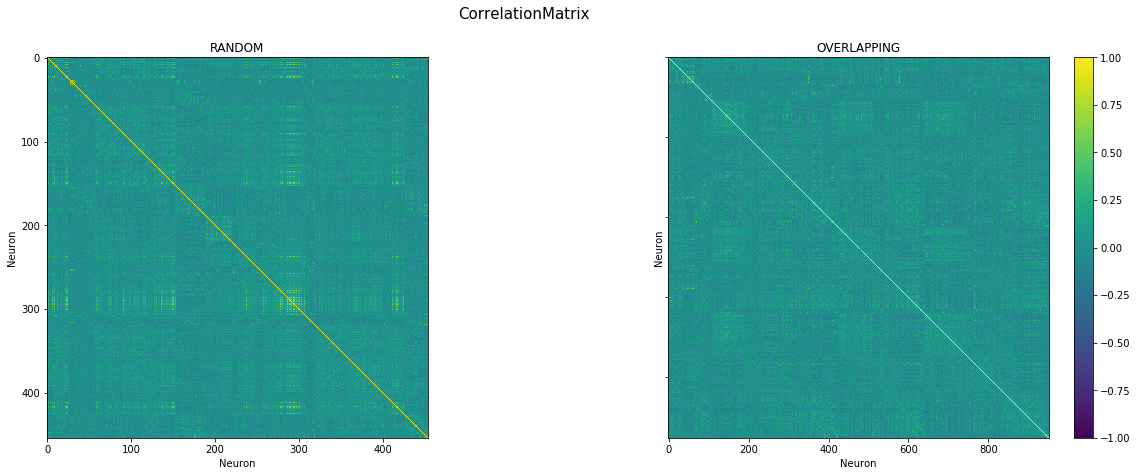

In [6]:
correlation_fig_path =  figure_path +'correlation_matrix_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                        '_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_matrix_conditions(matrix_list = correlation_matrix, save_path = correlation_fig_path,
                                        title = 'CorrelationMatrix' , conditions = task_list)


## Correlation matrix in different behavioural conditions

Behavioural condions here refers to resting periods (in between trials), non exploration periods (time inside the arena but not exploring the objects) and different objects exploration periods. Objects exploration are refered as the position they occupaid in the arena (LL, LR, UL, UR).
Two main figures are ploted from here, the correlation matrix for all behavioural conditions and the statistical analysis of the correlation values in those correlation matrix. 

First define all the files paths, and then load the data


In [7]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{100}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'


In [8]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf


Separate parts of the signal that belong to different bahavioural conditions. 

This activity will be saved in the list nerual_activity_new, and the correlation matrix will be computed and saved in corr_matrix list.

In [9]:
## compute entire correlation matrix
correlation_matrix = stats.corr_matrix(neural_activity = resample_neural_activity_mean)

#separate neural activity that belongs to traiing without testing trial

#test_position = 39
test_position = len(resample_timeline)-1

vector = resample_neural_activity_mean[:, :int(resample_timeline[test_position])]
vector_beh = resample_beh1 [:int(resample_timeline[test_position])]
#define list where data will be saved
neural_activity_new = []
corr_matrix = []
for i in range(6):
    neural_activity_new.append(vector[:,np.where(vector_beh== i)])
    corr_matrix.append(stats.corr_matrix(neural_activity = neural_activity_new[i][:,0,:]))
    #print(np.max(corr_matrix[i].flatten()))
    #print(np.min(corr_matrix[i].flatten()))
    #corr_matrix.append(stats.cov_matrix(neural_activity = neural_activity_new[i][:,0,:]))

Plot correlation matrix for the different behavioural conditions

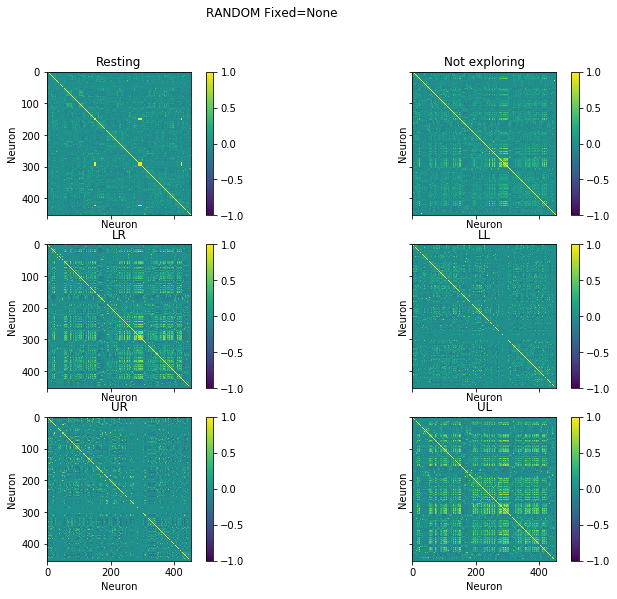

In [10]:
# define file name to save figure and plot
correlation_behaviour_path = figure_path +'correlation_matrix_task_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'

figs.plot_correlation_matrix_behaviour(corr_matrix_list = corr_matrix, path_save = correlation_behaviour_path, title = task +' Fixed=' +fixed)



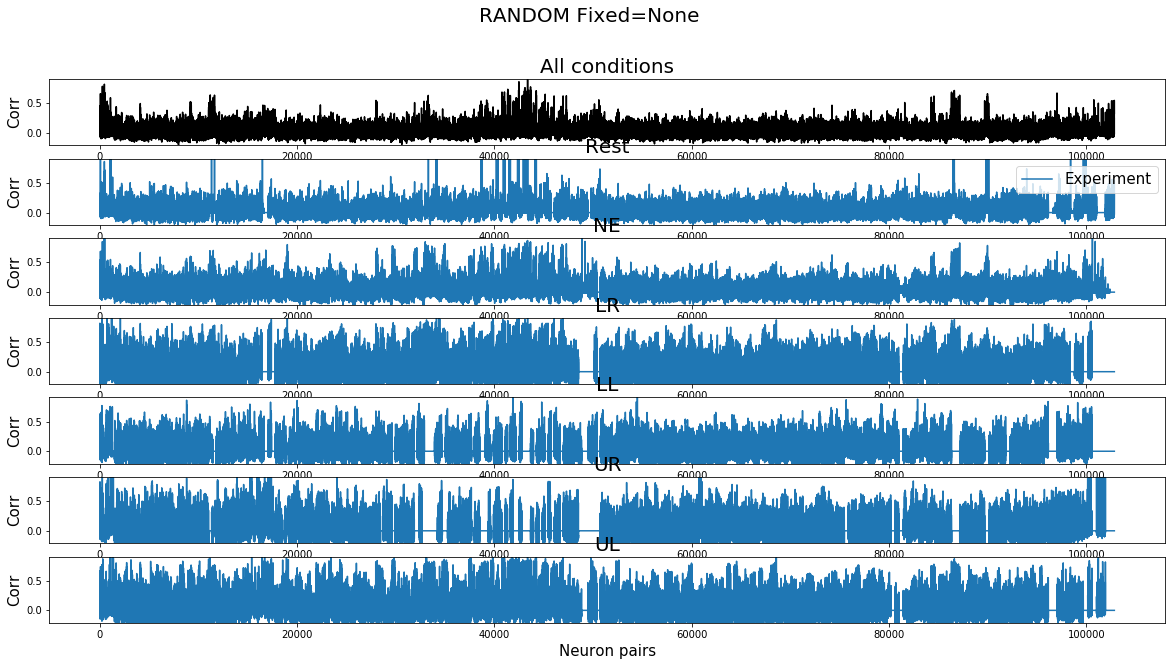

In [11]:
figure , axes = plt.subplots(7,1)
ax_titles = ['Rest','NE','LR','LL','UR','UL']
x = np.tril_indices_from(correlation_matrix,k=-1)
correlation_values = correlation_matrix[x]
axes[0].plot(correlation_values.flatten(),color = 'k')

vmin = min(correlation_values.flatten())
vmax = max(correlation_values.flatten())
axes[0].set_ylim(vmin,vmax)
axes[0].set_title('All conditions',fontsize= 20)
axes[0].set_ylabel('Corr', fontsize = 15)
for i in range(6):
    x = np.tril_indices_from(corr_matrix[i], k = -1)
    correlation_values = corr_matrix[i][x]
    axes[i+1].plot(correlation_values.flatten())
    axes[i+1].set_ylim(vmin,vmax)
    axes[i+1].set_title(ax_titles[i],fontsize= 20)
    axes[i+1].set_ylabel('Corr', fontsize = 15)

axes[i+1].set_xlabel('Neuron pairs', fontsize = 15)
axes[1].legend(['Experiment','Resting'],fontsize = 15)
figure.set_size_inches([20,10])
figure.suptitle(task +' Fixed=' +fixed, fontsize = 20)
correlation_pairs_path = figure_path +'correlation_behaviour_pairs_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figure.savefig(correlation_pairs_path)

Now, we will compare correlation matrix but using exploration events shorter and longer that 15s. This corresponds to an observation in overlapping trials that the overlapping object is less explored and during periords that are shorter that 20s (for example for one particular mouse). We want to see if there are differences when separating those conditions.

In [12]:
## load behavioural short and long events
beh_file_short = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_short.npy'
beh_file_long = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_long.npy'
## LOAD BEHAVIOUR SHORT AND LONG
behaviour_short = np.load(behaviour_dir + beh_file_short)
behaviour_long = np.load(behaviour_dir + beh_file_long)
reshape_behaviour_short = np.reshape(behaviour_short[:int(int(behaviour_short.shape[0]/re_sf)*re_sf)],(int(behaviour_short.shape[0]/re_sf),re_sf))
resample_beh_short = np.reshape(scipy.stats.mode(reshape_behaviour_short,axis=1)[0],reshape_behaviour_short.shape[0])
reshape_behaviour_long = np.reshape(behaviour_long[:int(int(behaviour_long.shape[0]/re_sf)*re_sf)],(int(behaviour_long.shape[0]/re_sf),re_sf))
resample_beh_long = np.reshape(scipy.stats.mode(reshape_behaviour_long,axis=1)[0],reshape_behaviour_long.shape[0])

In [13]:
vector_beh_short = resample_beh_short[:int(resample_timeline[len(resample_timeline)-1])]
vector_beh_long = resample_beh_long[:int(resample_timeline[len(resample_timeline)-1])]

#define list where data will be saved
neural_activity_short = []
neural_activity_long = []
corr_matrix_short = []
corr_matrix_long = []
for i in [0,1,2,3]:
    neural_activity_short.append(vector[:,np.where(vector_beh_short== i+2)])
    neural_activity_long.append(vector[:,np.where(vector_beh_long== i+2)])
    corr_matrix_short.append(stats.corr_matrix(neural_activity = neural_activity_short[i][:,0,:]))
    corr_matrix_long.append(stats.corr_matrix(neural_activity = neural_activity_long[i][:,0,:]))

1.007575757575758
-0.6917367334228984
1.0070921985815608
-0.6136109553258503
1.0222222222222226
-0.638164784080937
1.0088495575221252
-0.6026018768846318


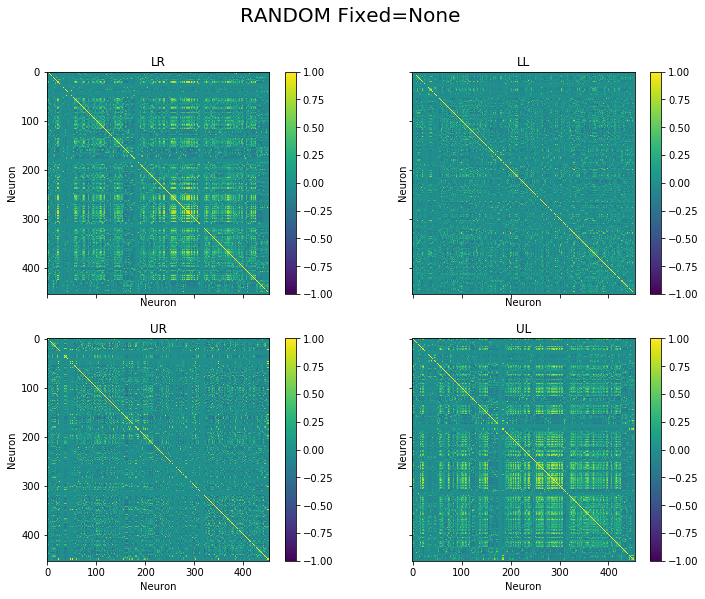

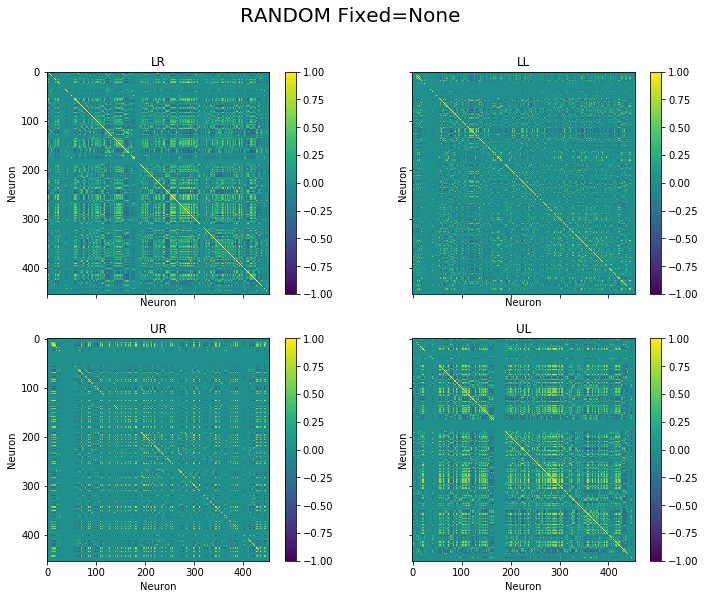

In [14]:
# define file name to save figure and plot
correlation_behaviour_path = figure_path +'correlation_matrix_task_short_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'

corr_matrix_list = corr_matrix_short
figure, axes = plt.subplots(2, 2)
images = []
for i in range(2):
    for j in range(2):
        images.append(axes[i, j].imshow(corr_matrix_list[i * 2 + j], cmap='viridis'))
        axes[i, j].label_outer()
        figure.colorbar(images[i], ax=axes[i, j])

vmin = -1
vmax = 1
# vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

axes[0, 0].set_title('LR', fontsize=12)
axes[0, 1].set_title('LL', fontsize=12)
axes[1, 0].set_title('UR', fontsize=12)
axes[1, 1].set_title('UL', fontsize=12)
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlabel('Neuron')
        axes[i, j].set_ylabel('Neuron')
figure.suptitle('Correlation matrix short exploration', fontsize = 20)
figure.set_size_inches(12, 9)
figure.suptitle(task +' Fixed=' +fixed, fontsize = 20)
figure.savefig(correlation_behaviour_path)


# define file name to save figure and plot
correlation_behaviour_path = figure_path +'correlation_matrix_task_long_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'

corr_matrix_list = corr_matrix_long
figure, axes = plt.subplots(2, 2)
images = []
for i in range(2):
    for j in range(2):
        images.append(axes[i, j].imshow(corr_matrix_list[i * 2 + j], cmap='viridis'))
        axes[i, j].label_outer()
        figure.colorbar(images[i], ax=axes[i, j])
        print(np.max(corr_matrix_list[i * 2 + j].flatten()))
        print(np.min(corr_matrix_list[i * 2 + j].flatten()))

vmin =-1
vmax = 1
# vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

axes[0, 0].set_title('LR', fontsize=12)
axes[0, 1].set_title('LL', fontsize=12)
axes[1, 0].set_title('UR', fontsize=12)
axes[1, 1].set_title('UL', fontsize=12)
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlabel('Neuron')
        axes[i, j].set_ylabel('Neuron')
figure.suptitle('Correlation matrix long exploration', fontsize = 20)
figure.set_size_inches(12, 9)
figure.suptitle(task +' Fixed=' +fixed, fontsize = 20)
figure.savefig(correlation_behaviour_path)



/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/melisa/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


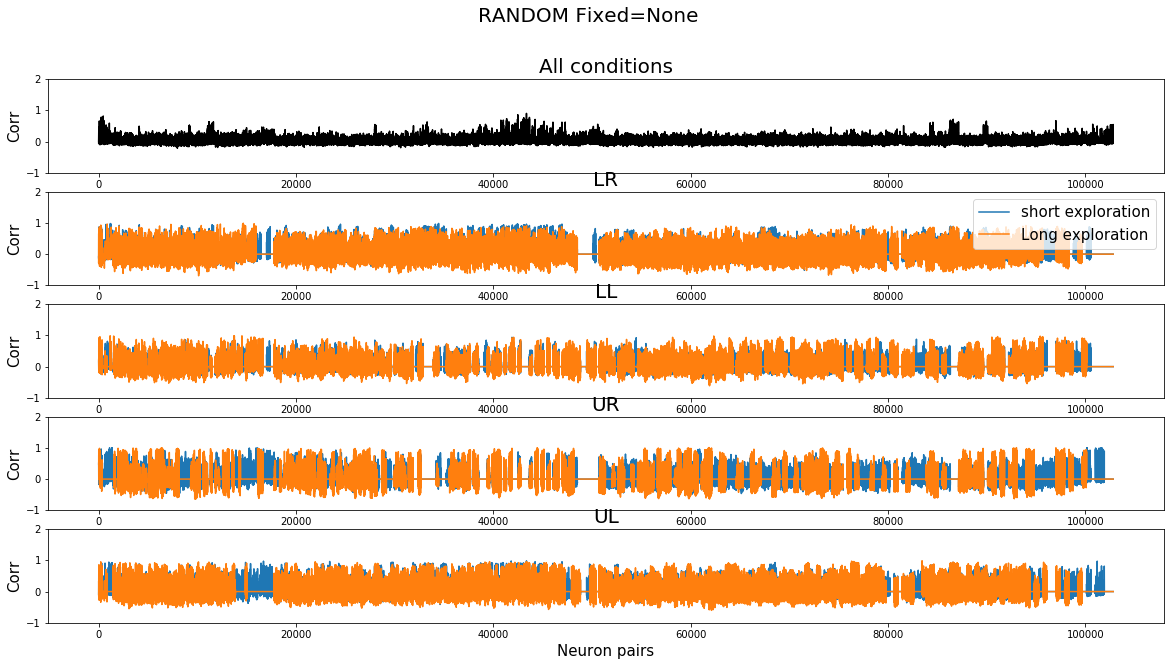

In [15]:
figure , axes = plt.subplots(5,1)
ax_titles = ['LR','LL','UR','UL']
x = np.tril_indices_from(correlation_matrix,k=-1)
correlation_values = correlation_matrix[x]
axes[0].plot(correlation_values.flatten(),color = 'k')
axes[0].set_ylim(-1,2)
axes[0].set_title('All conditions',fontsize= 20)
axes[0].set_ylabel('Corr', fontsize = 15)
for i in range(4):
    x = np.tril_indices_from(corr_matrix_short[i], k = -1)
    correlation_values = corr_matrix_short[i][x]
    axes[i+1].plot(correlation_values.flatten())
    x = np.tril_indices_from(corr_matrix_long[i], k = -1)
    correlation_values = corr_matrix_long[i][x]
    axes[i+1].plot(correlation_values.flatten())
    axes[i+1].set_ylim(-1,2)
    axes[i+1].set_title(ax_titles[i],fontsize= 20)
    axes[i+1].set_ylabel('Corr', fontsize = 15)

axes[i+1].set_xlabel('Neuron pairs', fontsize = 15)
axes[1].legend(['short exploration','Long exploration'],fontsize = 15)
figure.set_size_inches([20,10])
figure.suptitle(task +' Fixed=' +fixed, fontsize = 20)
correlation_pairs_path = figure_path +'correlation_behaviour_pairs_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figure.savefig(correlation_pairs_path)

Generate statistics over the correlation matrix values. Compute distribution, mean and std values and compare the different conditions by computing correlation between correlation matrix and KLD betwween the distributions. 

/home/melisa/Documents/neural_analysis/src/figures.py:161: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


[[1.         0.27140506 0.1668099  0.2016956  0.18698852 0.16615005]
 [0.27332936 1.         0.66170338 0.52653069 0.47822152 0.65862052]
 [0.16247957 0.65170339 1.         0.21707549 0.13561978 0.63032594]
 [0.17522224 0.48723788 0.21916986 1.         0.45381172 0.23564877]
 [0.16180736 0.44151819 0.12800211 0.45426764 1.         0.1253772 ]
 [0.16271173 0.65442727 0.62927228 0.23570651 0.126645   1.        ]]


/home/melisa/Documents/neural_analysis/src/figures.py:218: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.savefig(path_save)
/home/melisa/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the 

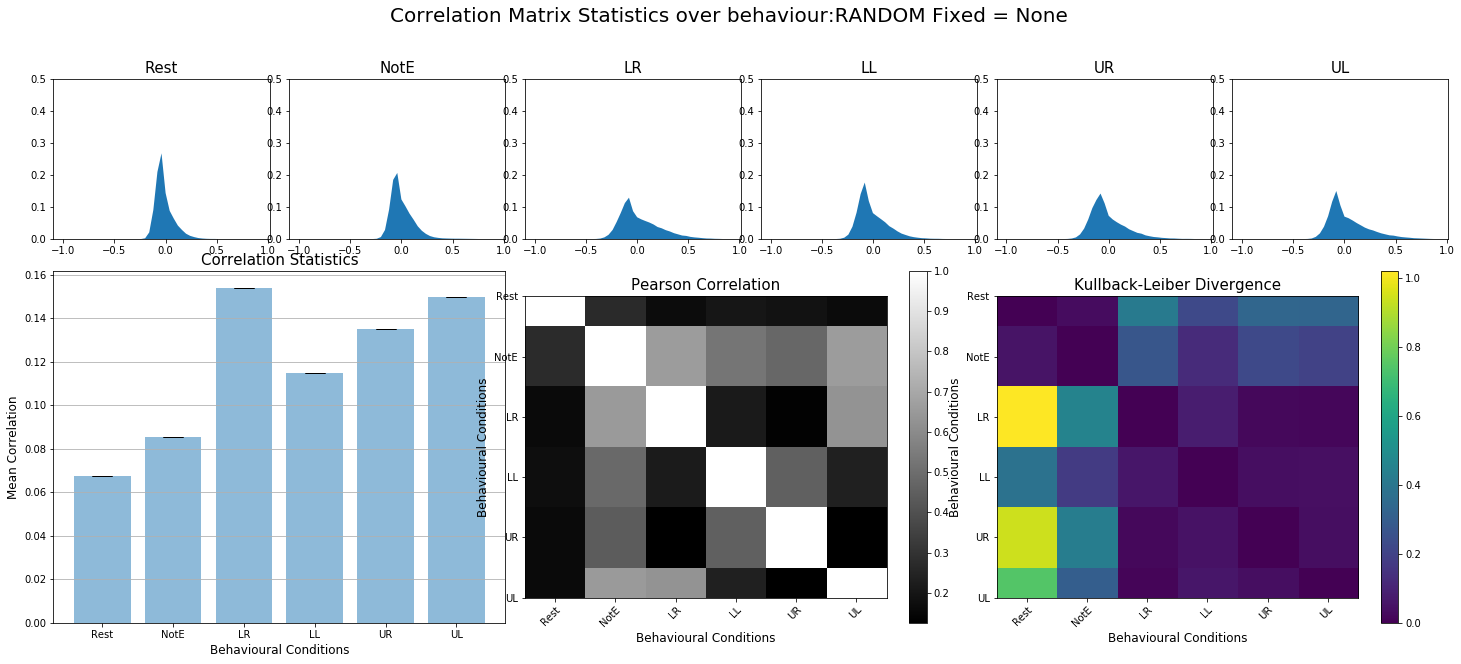

In [16]:
# define file name to save figure and plot
correlation_stats_path = figure_path +'correlation_statistics_mouse_'+f'{mouse}'+'_session_'\
                         +f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_behaviour(corr_matrix=corr_matrix, task = task + ' Fixed = ' + fixed, path_save=correlation_stats_path)

Now, the same statistical analysis but for short and long exploration events

In [17]:
import math
corr_mean_short = np.zeros(len(corr_matrix_short))
corr_error_short = np.zeros(len(corr_matrix_short))
for i in range(len(corr_matrix_short)):
    corr_mean_short[i] = np.mean(np.abs(corr_matrix_short[i].flatten()))
    corr_error_short[i] = np.std(np.abs(corr_matrix_short[i].flatten()))/math.sqrt(corr_matrix_short[i].flatten().shape[0])
    
corr_mean_long = np.zeros(len(corr_matrix_long))
corr_error_long = np.zeros(len(corr_matrix_long))
for i in range(len(corr_matrix_long)):
    corr_mean_long[i] = np.mean(np.abs(corr_matrix_long[i].flatten()))
    corr_error_long[i] = np.std(np.abs(corr_matrix_long[i].flatten()))/math.sqrt(corr_matrix_long[i].flatten().shape[0])

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


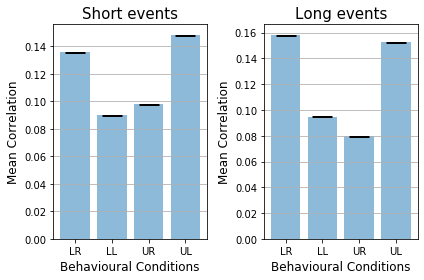

In [18]:
fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(1, 2)    
ax1 = fig.add_subplot(gs[0, 0])
conditions= ['LR','LL','UR','UL']
x_pos = np.arange(len(conditions))
ax1.bar(x_pos, corr_mean_short, yerr=corr_error_short, align='center', alpha=0.5, ecolor='black', capsize=10)
ax1.set_ylabel('Mean Correlation', fontsize = 12)
ax1.set_xlabel('Behavioural Conditions', fontsize = 12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(conditions)
ax1.set_title('Short events', fontsize = 15)
ax1.yaxis.grid(True)
#ax1.set_ylim(0,0.1)
fig.tight_layout()

ax2 = fig.add_subplot(gs[0, 1])
conditions= ['LR','LL','UR','UL']
x_pos = np.arange(len(conditions))
ax2.bar(x_pos, corr_mean_long, yerr=corr_error_long, align='center', alpha=0.5, ecolor='black', capsize=10)
ax2.set_ylabel('Mean Correlation', fontsize = 12)
ax2.set_xlabel('Behavioural Conditions', fontsize = 12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(conditions)
ax2.set_title('Long events', fontsize = 15)
ax2.yaxis.grid(True)
#ax2.set_ylim(0,0.1)
fig.tight_layout()

(-1, 1)

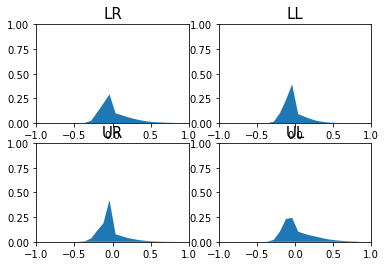

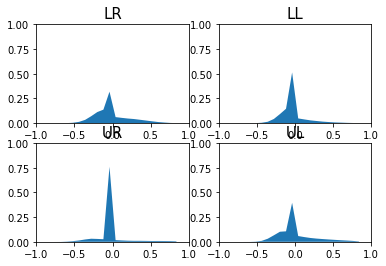

In [19]:
nbins = 25
fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('LR', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_short[0].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax1.fill_between(bin_num[:-1],counter / np.sum(counter))
ax1.set_ylim(0,1)
ax1.set_xlim(-1,1)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('LL', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_short[1].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax2.fill_between(bin_num[:-1],counter / np.sum(counter))
ax2.set_ylim(0,1)
ax2.set_xlim(-1,1)


ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title('UR', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_short[2].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax3.fill_between(bin_num[:-1],counter / np.sum(counter))
ax3.set_ylim(0,1)
ax3.set_xlim(-1,1)

ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title('UL', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_short[3].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax4.fill_between(bin_num[:-1],counter / np.sum(counter))
ax4.set_ylim(0,1)
ax4.set_xlim(-1,1)


fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('LR', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_long[0].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax1.fill_between(bin_num[:-1],counter / np.sum(counter))
ax1.set_ylim(0,1)
ax1.set_xlim(-1,1)


ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('LL', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_long[1].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax2.fill_between(bin_num[:-1],counter / np.sum(counter))
ax2.set_ylim(0,1)
ax2.set_xlim(-1,1)

ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title('UR', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_long[2].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax3.fill_between(bin_num[:-1],counter / np.sum(counter))
ax3.set_ylim(0,1)
ax3.set_xlim(-1,1)

ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title('UL', fontsize = 15)
[counter,bin_num] = np.histogram(corr_matrix_long[3].flatten(),bins=np.arange(-1, 1,2 / nbins))
ax4.fill_between(bin_num[:-1],counter / np.sum(counter))
ax4.set_ylim(0,1)
ax4.set_xlim(-1,1)


## Correlation matrix over days and trials

Analysis of the evaluation of the correlation matrix over different days of the experiment and over different trials.

### Days of the experiment

In [20]:
## Separate neural activity belonging to different days of the experiment, considering as different the resting
# and the trial parts.

neural_activity1_days = []
time_length = np.diff(resample_timeline)
#print(time_length)
#print(len(time_length))

days = int(len(resample_timeline)/10)+1
days = 4

for i in range(days):
    day_matrix = np.zeros((neural_activity1.shape[0],int(np.sum(time_length[i*10:(i+1)*10:2]))))
    start_time = 0
    for j in range(0,10,2):
        trial = i*10 + j
        if trial < len(resample_timeline)-1:
            day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
                neural_activity1[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
            start_time = start_time + int(time_length[trial])
    neural_activity1_days.append(day_matrix)

neural_activity1_resting_days = []
time_length = np.diff(resample_timeline)
for i in range(days):
    day_matrix = np.zeros((neural_activity1.shape[0],int(np.sum(time_length[i*10+1:(i+1)*10+1:2]))))
    start_time = 0
    for j in range(1,10,2):
        trial = i*10 + j
        if trial < len(resample_timeline)-1:
            day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
                neural_activity1[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
            start_time = start_time + int(time_length[trial])
    neural_activity1_resting_days.append(day_matrix)

neural_activity1_resting_testing = neural_activity1[:,int(resample_timeline[-2]):int(resample_timeline[-1])]
neural_activity1_testing = neural_activity1[:,int(resample_timeline[-3]):int(resample_timeline[-2])]


Compute correlation matrix for the different subsets of neural activity, including separately the testing day. Correlation matrix are saved in lists. 

In [21]:

corr_matrix_days = []
for i in range(days):
    corr_matrix_days.append(stats.corr_matrix(neural_activity = neural_activity1_days[i]))
    #corr_matrix_days.append(stats.cov_matrix(neural_activity = neural_activity1_days[i]))

corr_matrix_days.append(stats.corr_matrix(neural_activity = neural_activity1_testing))
#corr_matrix_days.append(stats.cov_matrix(neural_activity = neural_activity1_testing))

corr_matrix_resting_days = []
for i in range(days):
    corr_matrix_resting_days.append(stats.corr_matrix(neural_activity = neural_activity1_resting_days[i]))
    #corr_matrix_resting_days.append(stats.cov_matrix(neural_activity = neural_activity1_resting_days[i]))
corr_matrix_resting_days.append(stats.corr_matrix(neural_activity = neural_activity1_resting_testing))
#corr_matrix_resting_days.append(stats.cov_matrix(neural_activity = neural_activity1_resting_testing))

print(len(corr_matrix_days))

5


For analyzing the correlation matrix over days plot statistics and correlations over them. Here we plot the mean values (and error of the mean) of correlation matrix over multiple days, the correlation between different days correlation matrix and the Kullback-Leiber Divergence of the distributions of correlation values during diferent days. Note: Correlation of correlation matrix is simetric while KLD is not!

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


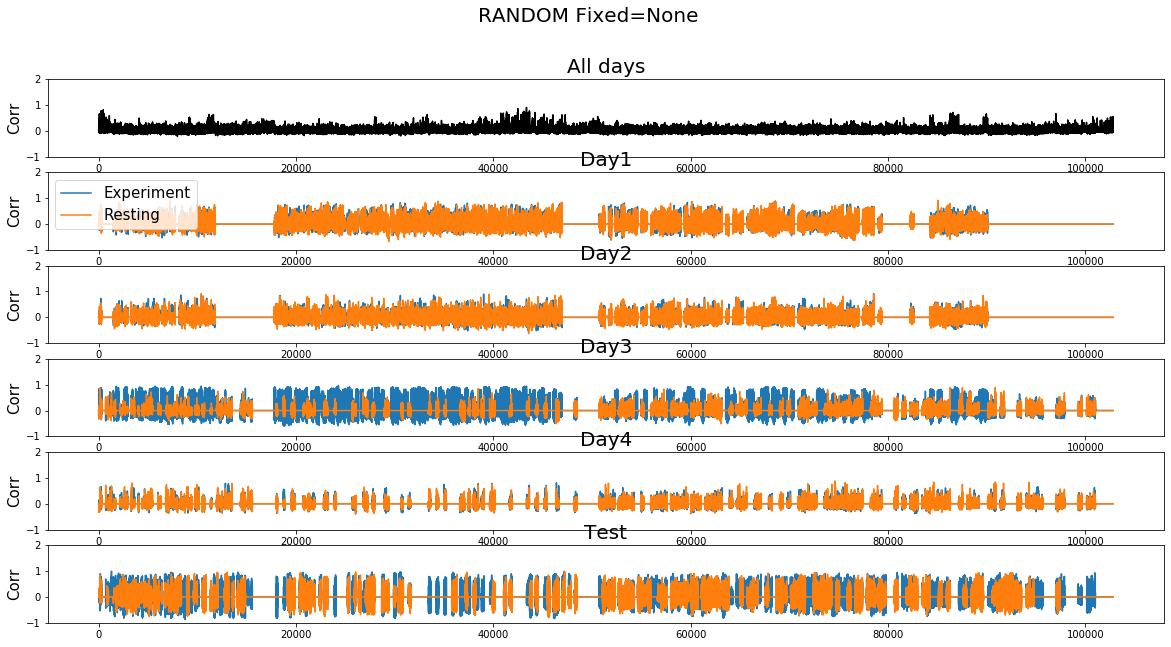

In [22]:
figure , axes = plt.subplots(6,1)
ax_titles = ['Day1','Day2','Day3','Day4','Test']
x = np.tril_indices_from(correlation_matrix,k=-1)
correlation_values = correlation_matrix[x]
axes[0].plot(correlation_values.flatten(),color = 'k')
axes[0].set_ylim(-1,2)
axes[0].set_title('All days',fontsize= 20)
axes[0].set_ylabel('Corr', fontsize = 15)

days = int(len(resample_timeline)/10)+1
days = 5

for i in range(days):
    x = np.tril_indices_from(corr_matrix_days[i], k = -1)
    correlation_values = corr_matrix_days[i][x]
    axes[i+1].plot(correlation_values.flatten())
    x = np.tril_indices_from(corr_matrix_resting_days[i], k = -1)
    correlation_values = corr_matrix_resting_days[i][x]
    axes[i+1].plot(correlation_values.flatten())
    axes[i+1].set_ylim(-1,2)
    axes[i+1].set_title(ax_titles[i],fontsize= 20)
    axes[i+1].set_ylabel('Corr', fontsize = 15)

axes[i].set_xlabel('Neuron pairs', fontsize = 15)
axes[1].legend(['Experiment','Resting'],fontsize = 15)
figure.set_size_inches([20,10])
figure.suptitle(task +' Fixed=' +fixed, fontsize = 20)
correlation_pairs_path = figure_path +'correlation_pairs_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figure.savefig(correlation_pairs_path)

/home/melisa/Documents/neural_analysis/src/figures.py:289: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


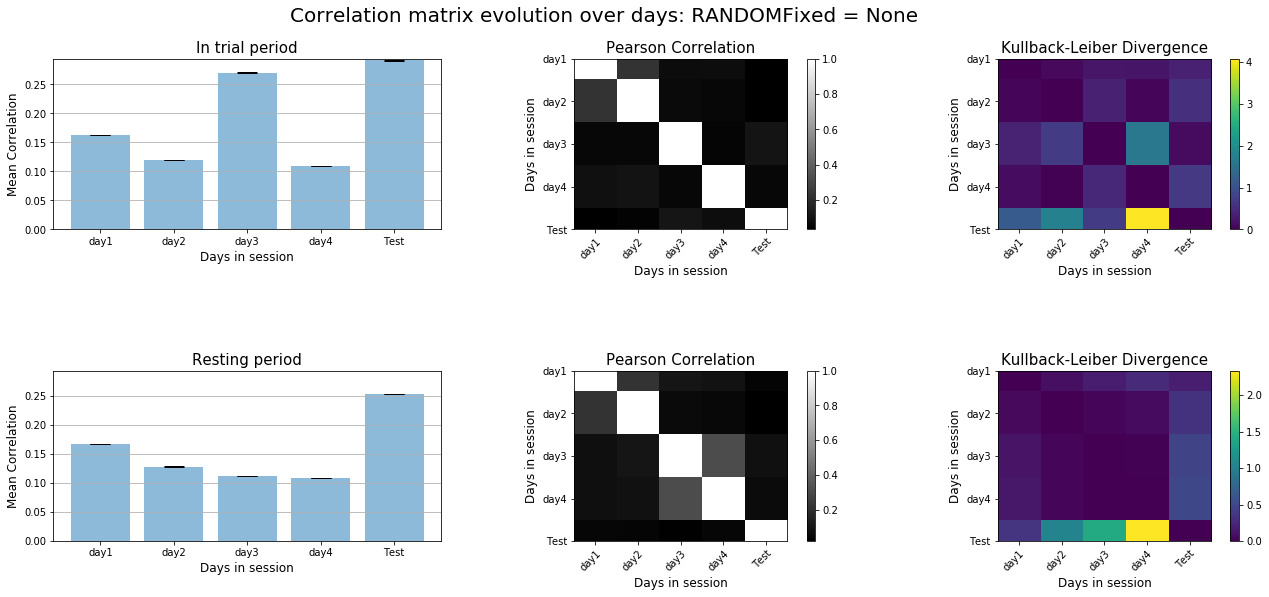

In [23]:
# define the path to save the figure and plot
correlation_path = figure_path +'correlation_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_learning(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                     path_save=correlation_path, title=task + 'Fixed = '+ fixed)

/home/melisa/Documents/neural_analysis/src/figures.py:244: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.savefig(path_save)


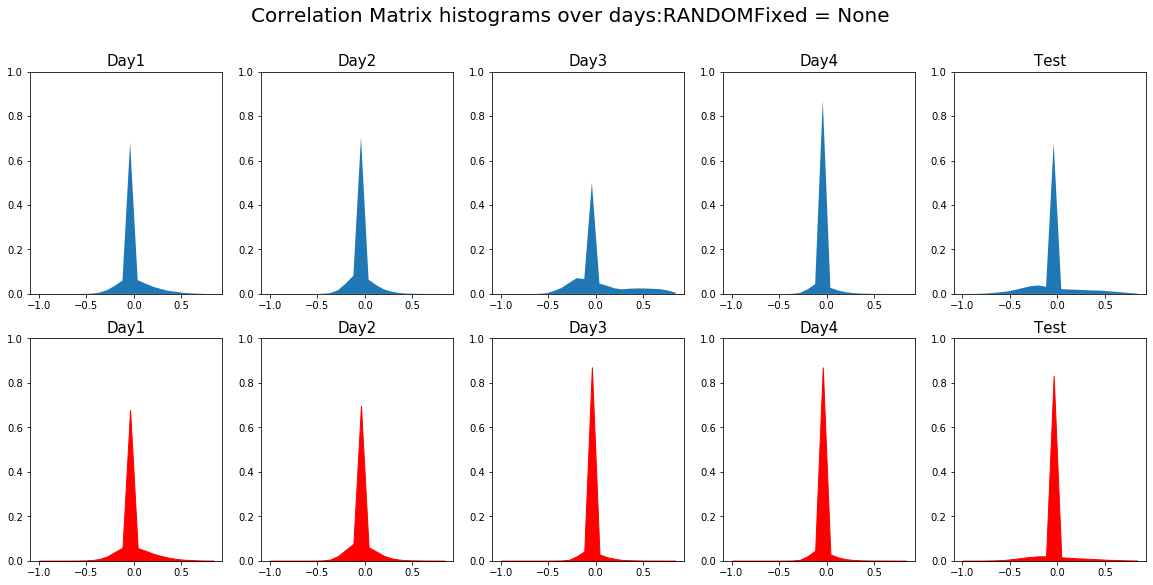

In [24]:
correlation_path = figure_path +'correlation_hist_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_histograms_learning(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                     path_save=correlation_path, title=task + 'Fixed = '+ fixed, nbins = 25)

### Trials of the experiment

Fisrt separate the data corresponding to different trials by using the timeline data, and then compute correlation matrix for each trial.

In [25]:
# Separate neural activity for different trials and save in the neural_activity_days and
# neural_activity_resting_days lists.

neural_activity1_days = []
time_length = np.diff(resample_timeline)
ntrials = len(resample_timeline)-1

ntrials = 42
for i in range(0,ntrials,2):
    trial_matrix = neural_activity1[:,int(resample_timeline[i]):int(resample_timeline[i]) + int(time_length[i])]
    neural_activity1_days.append(trial_matrix)

neural_activity1_resting_days = []
for i in range(1,ntrials,2):
    trial_matrix = neural_activity1[:,int(resample_timeline[i]):int(resample_timeline[i]) + int(time_length[i])]
    neural_activity1_resting_days.append(trial_matrix)


In [26]:
corr_matrix_days = []
for i in range(len(neural_activity1_days)):
    corr_matrix_days.append(stats.corr_matrix(neural_activity = neural_activity1_days[i]))
    #corr_matrix_days.append(stats.cov_matrix(neural_activity = neural_activity1_days[i]))
corr_matrix_resting_days = []
for i in range(len(neural_activity1_resting_days)):
    corr_matrix_resting_days.append(stats.corr_matrix(neural_activity = neural_activity1_resting_days[i]))
    #corr_matrix_resting_days.append(stats.cov_matrix(neural_activity = neural_activity1_resting_days[i]))

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


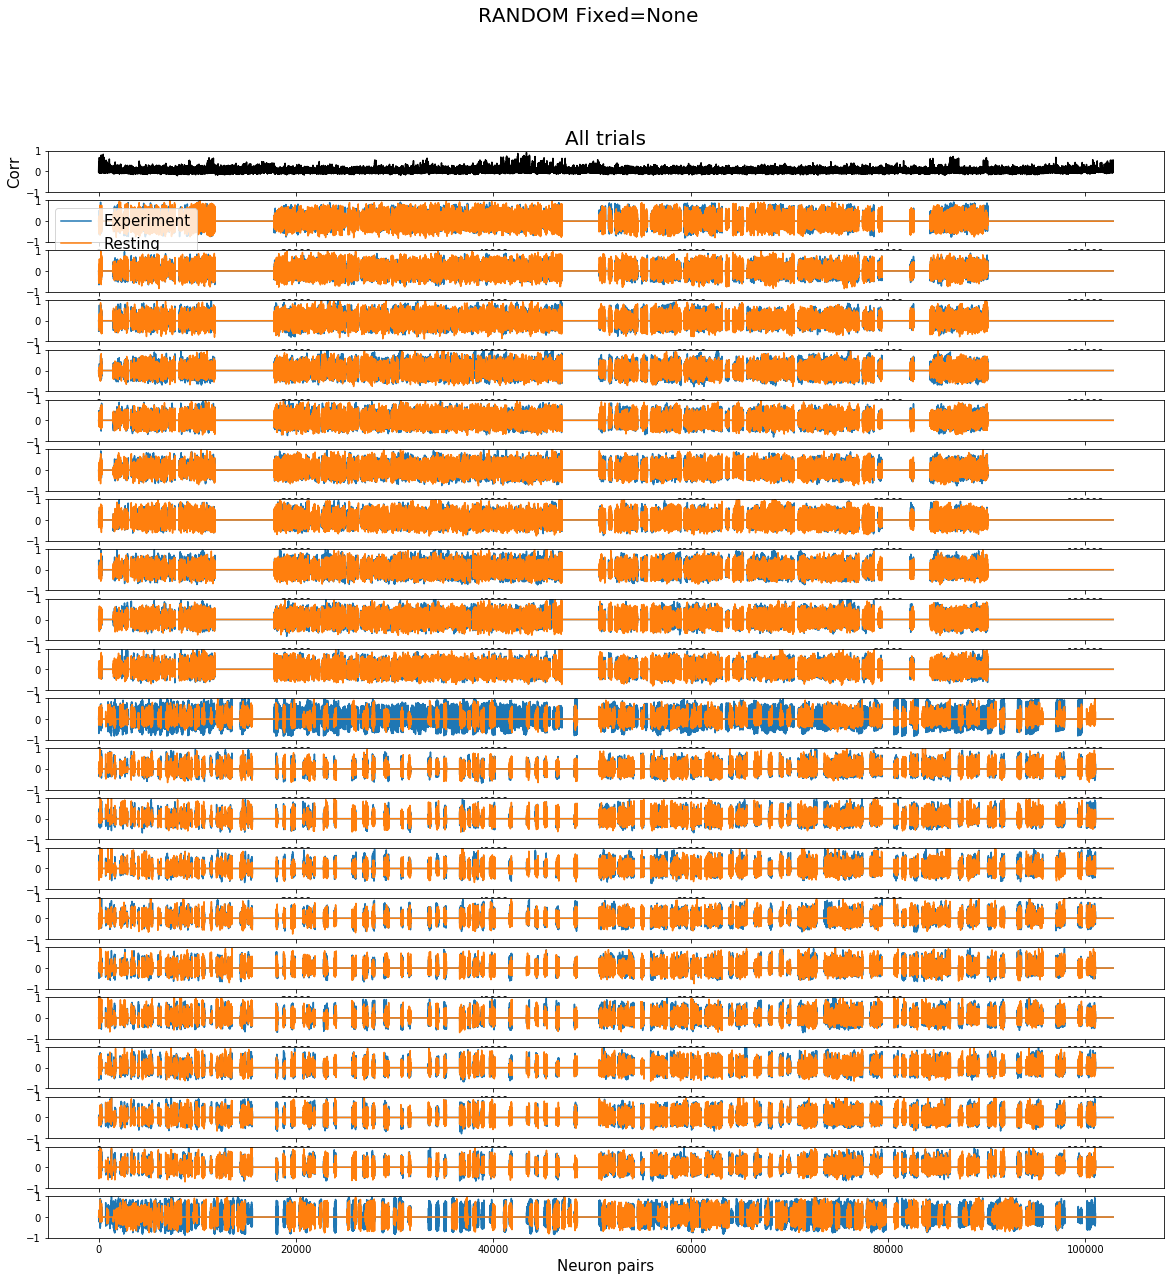

In [27]:
figure , axes = plt.subplots(22,1)
x = np.tril_indices_from(correlation_matrix,k=-1)
correlation_values = correlation_matrix[x]
axes[0].plot(correlation_values.flatten(),color = 'k')
axes[0].set_ylim(-1,1)
axes[0].set_title('All trials',fontsize= 20)
axes[0].set_ylabel('Corr', fontsize = 15)

for i in range(len(corr_matrix_resting_days)):
    x = np.tril_indices_from(corr_matrix_days[i],k=-1)
    correlation_values = corr_matrix_days[i][x]
    axes[i+1].plot(correlation_values.flatten())
    x = np.tril_indices_from(corr_matrix_resting_days[i],k=-1)
    correlation_values = corr_matrix_resting_days[i][x]    
    axes[i+1].plot(correlation_values.flatten())
    axes[i+1].set_ylim(-1,1)

axes[i+1].set_xlabel('Neuron pairs', fontsize = 15)
axes[1].legend(['Experiment','Resting'],fontsize = 15)
figure.set_size_inches([20,20])
figure.suptitle(task +' Fixed=' +fixed, fontsize = 20)
correlation_pairs_path = figure_path +'correlation_pairs_trials_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figure.savefig(correlation_pairs_path)

/home/melisa/Documents/neural_analysis/src/figures.py:476: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.savefig(path_save)


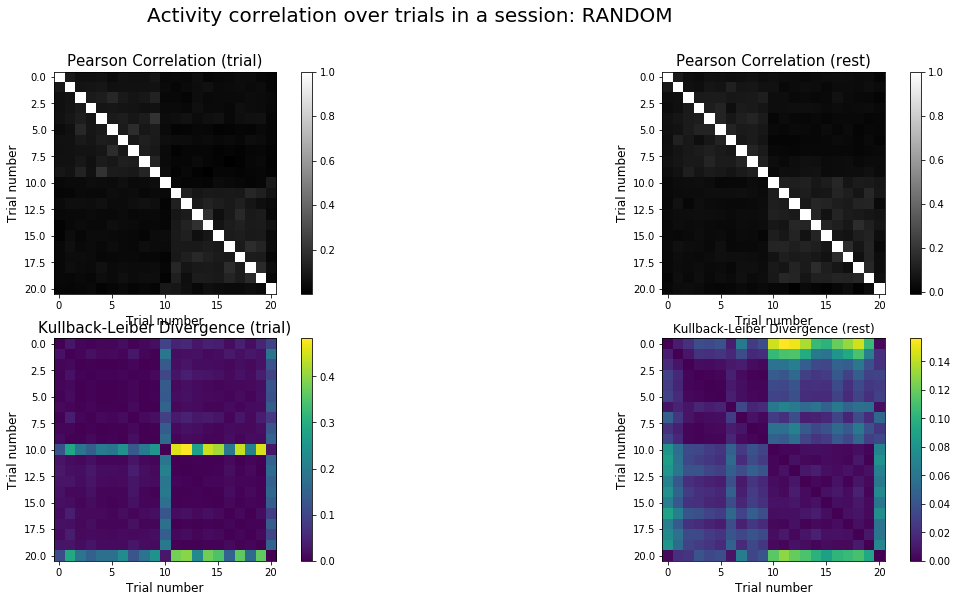

In [28]:
# define figure save path and plot
correlation_path = figure_path +'correlation_mouse_trials_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_trials(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                     path_save=correlation_path, title=task)


## Correlation matrix and object positions

Now we focus in the relationship between the neural correlation matrix and the object positions and repetitions of object positions (as enviromnetal configuration changes). The key idea is to search for a neural representation of environmental configuration. 

In general there are 6 posible configurations. In Overlapping condition only three are explored, in stable only one and random has the 6 posible configurations. 

We separated the analysis in two: conting number of overlapping (0, 1 or 2) objects in multiple trials or exact repetition of object configuration in different trials. For this we used correlation matrix computed in the previous steps for trial by trial analysis.


### Overlapping analysis. 

Using object position information to check the number of overlapping with other trials. 

Correlation matrix are the same as before but here we also plot the overlapping matrix that represents when teh condition is the same, similar or totaly different in between two trials. 


In [29]:
# load overlapping information
overlapping_objects_file = objects_dir + 'overlapping_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
overlapping_matrix = np.load(overlapping_objects_file)

/home/melisa/Documents/neural_analysis/src/figures.py:538: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.savefig(path_save)


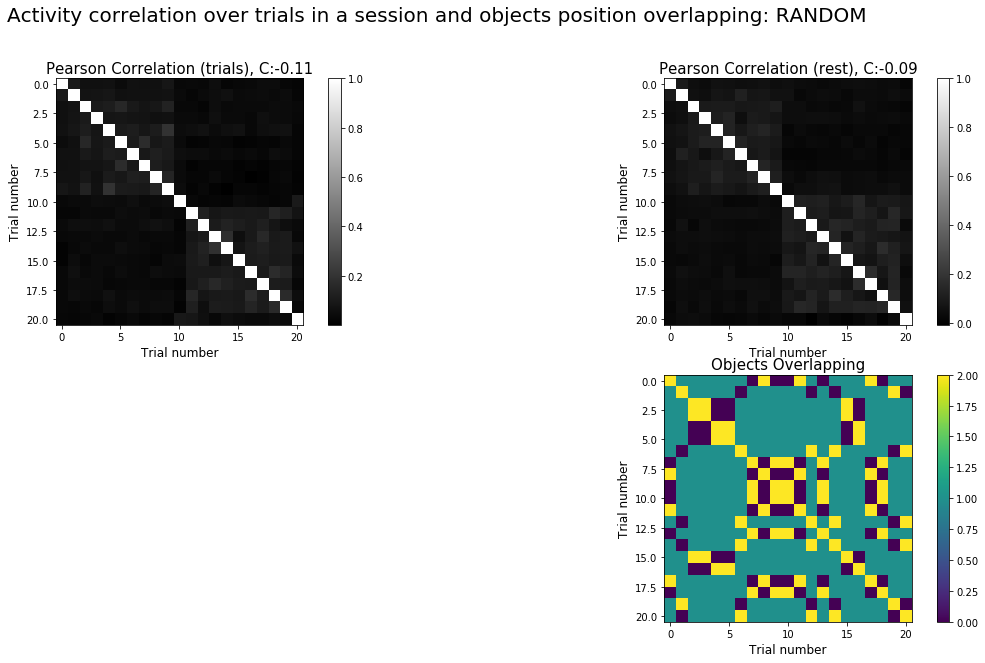

In [30]:
# define path to save figura and plot
objects_fig_path = figure_path +'correlation_with_object_position_'+f'{mouse}'+\
                   '_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_objects(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                         overlapping_matrix=overlapping_matrix, path_save=objects_fig_path,
                                    title=task)

### Enviromental configuration analysis

Now we analyze the two object position in simultaneous as a environment configurations. For that we compute the correlation matrix as before, but for visualization we reaorganized it so trials that belong to the same configuration are together (as represented in the configuration matrix, that shows one for same configuration and cero for different in between trials). 

As before we use the correlation matrix computed previously for trial by trial correlation matrix analysis. 

In [31]:
# load the information about object configurations. This files have the configuration vector
# (a vector with values 1 to 6 for the different configurations) and the configuration matrix 
# (a matrix that has ones for trials with the same configuration and cero for different)

condition_objects_file = objects_dir + 'condition_vector_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
condition_objects_file_matrix = objects_dir + 'condition_matrix_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'

condition_vector= np.load(condition_objects_file)
condition_matrix= np.load(condition_objects_file_matrix)

In [32]:
#reorder trials acording to conditon (objects configuration)
new_corr_matrix_days = []
new_corr_matrix_resting_days = []
new_condition_matrix = np.zeros((condition_vector.shape[0],condition_vector.shape[0]))
counter = 0
repetitions = []
for condition in range(1,7):
    positions = np.where(condition_vector == condition)
    if positions[0].shape[0] > 0:
        repetitions.append(positions[0].shape[0])
        for j in positions[0]:
            new_corr_matrix_days.append(corr_matrix_days[j])
            new_corr_matrix_resting_days.append(corr_matrix_resting_days[j])
            counter = counter +1

rep_cumsum = np.zeros((len(repetitions)+1))
rep_cumsum[1:]= np.cumsum(repetitions)
for rep in range(len(repetitions)):
    for i in range(int(rep_cumsum[rep]),int(rep_cumsum[rep+1])):
        for j in range(int(rep_cumsum[rep]),int(rep_cumsum[rep+1])):
            new_condition_matrix[i,j] = 1

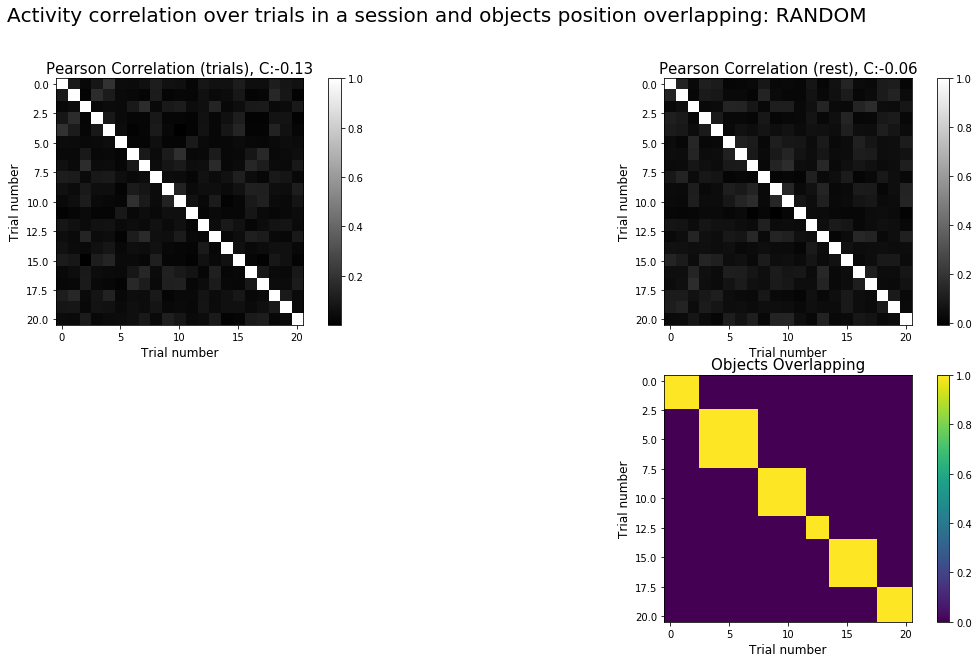

In [33]:
# define path to save figura and plot
objects_fig_path = figure_path + 'correlation_with_object_configuration_'+f'{mouse}'+\
                   '_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_objects(corr_matrix1=new_corr_matrix_days, corr_matrix2=new_corr_matrix_resting_days,
                                         overlapping_matrix=new_condition_matrix, path_save=objects_fig_path,
                                    title=task)

## Evolution of correlation with resting over trials

Here the question is whether there is any correlation between pre and post trial activity. So, we computed the correlation between the correlation matrix during the trial and the pre and post resting activity. 

For this, only correlation matrix computed before for trial by trial analysis are requird (for trial and resting periods). 

pos1=79524
pos2=79524
pos1=80089
pos2=80089
pos1=80089
pos2=79524
pos1=79524
pos2=77284
pos1=77841
pos2=77841
pos1=78961
pos2=78961
pos1=78400
pos2=78400
pos1=78961
pos2=78400
pos1=78961
pos2=77841
pos1=78400
pos2=77841
pos1=106929
pos2=30625
pos1=35721
pos2=35721
pos1=35721
pos2=35344
pos1=35344
pos2=35344
pos1=35721
pos2=35344
pos1=34969
pos2=34969
pos1=35721
pos2=35721
pos1=35721
pos2=35721
pos1=35721
pos2=35721
pos1=35721
pos2=35721
pos1=71289
pos2=38416


/home/melisa/Documents/neural_analysis/src/figures.py:575: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.savefig(path_save)


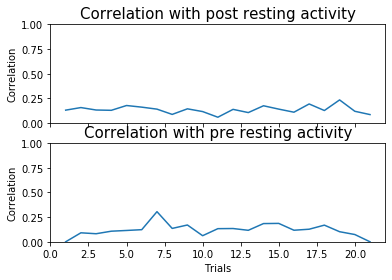

In [34]:
# define path to save the figure and plot
corr_evol_path = figure_path + 'correlation_with_resting_evoluction_'+f'{mouse}'+\
                   '_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'

figs.plot_correlation_with_resting_evolution(corr_matrix1 = corr_matrix_days, corr_matrix2 =corr_matrix_resting_days,path_save = corr_evol_path)
